# CRACKrete: A Deep Learning-Based Image Classification Tool for Concrete Crack Detection

## Step 1: Setting Up Your Environment

In [13]:
pip install tensorflow opencv-python matplotlib scikit-learn kaggle


## Step 2: Load and Explore the Dataset

In [14]:

!kaggle datasets download ahsanulislam/concrete-surface-image-filtered-with-match-filter


Dataset URL: https://www.kaggle.com/datasets/ahsanulislam/concrete-surface-image-filtered-with-match-filter
License(s): copyright-authors
concrete-surface-image-filtered-with-match-filter.zip: Skipping, found more recently modified local copy (use --force to force download)


In [15]:
import zipfile
import os

# Path to the downloaded ZIP file
zip_path = 'concrete-surface-image-filtered-with-match-filter.zip'

# Extract the contents
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('./data/')  # Specify the extraction path


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
from collections import Counter

# Custom image preprocessing function
def preprocess_image(img):
    # Ensure the image is in the correct type (float32 for processing)
    img = np.float32(img)

    # Convert the image to grayscale if it's a color image
    if len(img.shape) == 3:  # RGB or BGR image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # Apply edge detection using Canny (need uint8)
    edges = cv2.Canny(np.uint8(blurred * 255), threshold1=30, threshold2=100)  # Convert back to uint8

    # Convert single-channel (grayscale) back to 3 channels (RGB)
    edges_rgb = np.repeat(edges[..., np.newaxis], 3, axis=-1)  # Repeat the single channel into 3 channels

    return edges_rgb

# ImageDataGenerator with preprocessing
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,  # Apply custom preprocessing function
    validation_split=0.2  # Keep validation split
)

# Load training and validation data
train_data = datagen.flow_from_directory(
    './data/Matched Filter/',
    target_size=(227, 227),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_data = datagen.flow_from_directory(
    './data/Matched Filter/',
    target_size=(227, 227),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Check class distribution in the training data
counter = Counter(train_data.classes)
print(f"Class Distribution: {counter}")


Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Class Distribution: Counter({0: 16000, 1: 16000})


(32, 227, 227, 3)
[1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1.]


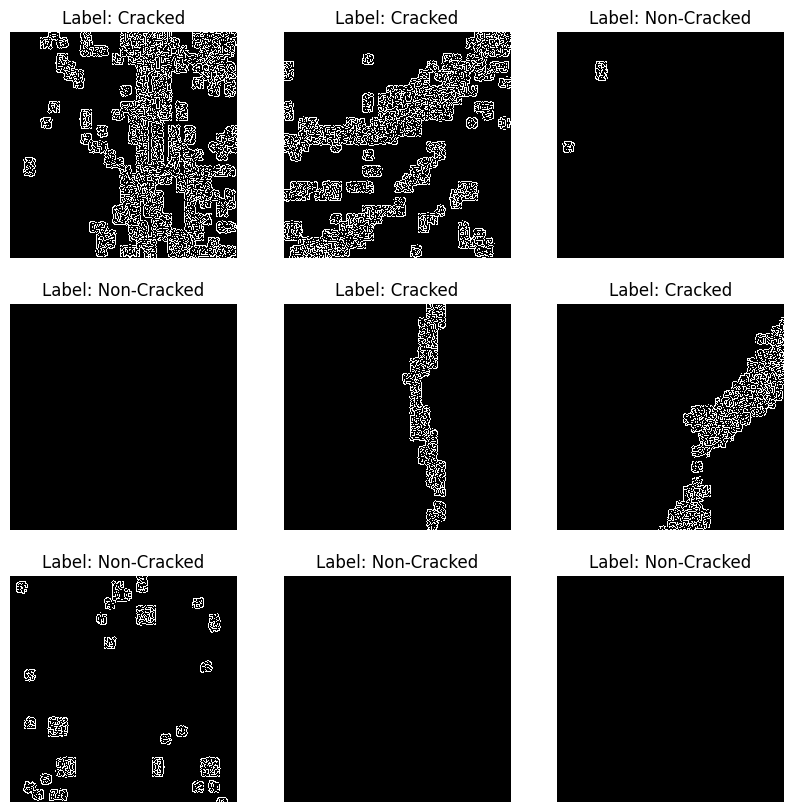

In [21]:
import matplotlib.pyplot as plt

# Get a batch of images and labels from the training data
# Inspect one batch from the train_data generator
x_batch, y_batch = next(train_data)
print(x_batch.shape)  # Should be (batch_size, 227, 227, 1) for grayscale or (227, 227, 3) for RGB
print(y_batch)  # Corresponding labels


# Plot a few images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i], cmap='gray')
    plt.title(f'Label: {"Cracked" if y_batch[i] == 1 else "Non-Cracked"}')
    plt.axis('off')
plt.show()


## Step 3: Build the CNN Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the CNN model
# Modified CNN model to reduce parameters
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(227, 227, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolutional Layer (added more pooling)
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 4th Convolutional Layer (optional to go deeper)
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening
model.add(Flatten())

# Dense Layer with fewer neurons
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Display model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 225, 225, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 110, 110, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 53, 53, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,359,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,747,841 (10.48 MB)

 Trainable params: 2,747,841 (10.48 MB)

 Non-trainable params: 0 (0.00 B)

## Step 4:Train the model

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
# Train the model
history = model.fit(
    train_data,
    epochs=10,  # Start with 10 epochs
    validation_data=val_data
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 148s 139ms/step - accuracy: 0.9043 - loss: 0.9417 - val_accuracy: 0.9650 - val_loss: 0.0781
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 121s 120ms/step - accuracy: 0.9639 - loss: 0.0726 - val_accuracy: 0.9852 - val_loss: 0.0392
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 117s 117ms/step - accuracy: 0.9828 - loss: 0.0504 - val_accuracy: 0.9820 - val_loss: 0.0447
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 139s 138ms/step - accuracy: 0.9854 - loss: 0.0423 - val_accuracy: 0.9825 - val_loss: 0.0407
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 119s 118ms/step - accuracy: 0.9877 - loss: 0.0385 - val_accuracy: 0.9844 - val_loss: 0.0359
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 140s 116ms/step - accuracy: 0.9880 - loss: 0.0322 - val_accuracy: 0.9872 - val_loss: 0.0315
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 119s 118ms/step - accuracy: 0.9887 - loss: 0.0325 - val_accuracy: 0.9874 - val_loss: 0.0366
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 118s 118ms/step - accuracy: 0.9

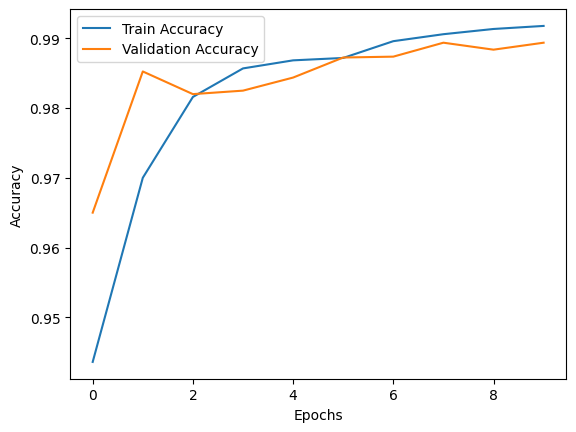

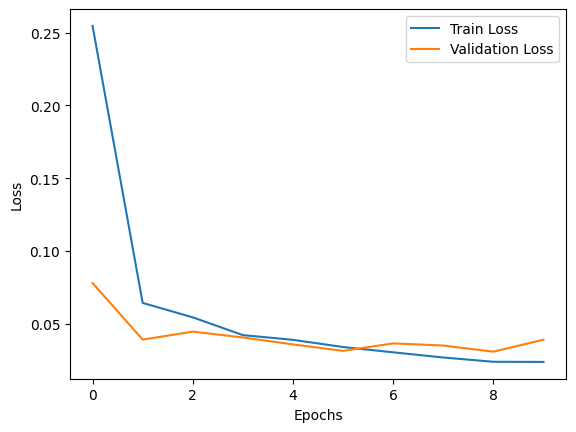

In [24]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Step 5: Evaluate the Model

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions for validation data
val_preds = model.predict(val_data)
val_preds_classes = np.where(val_preds > 0.5, 1, 0)  # Convert probabilities to binary predictions

# Get the true labels
true_classes = val_data.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, val_preds_classes)

# Display confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Classification report (precision, recall, f1-score)
class_report = classification_report(true_classes, val_preds_classes, target_names=['Non-Cracked', 'Cracked'])
print("Classification Report:")
print(class_report)


250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 113ms/step
Confusion Matrix:
[[1966 2034]
 [2047 1953]]
Classification Report:
              precision    recall  f1-score   support

 Non-Cracked       0.49      0.49      0.49      4000
     Cracked       0.49      0.49      0.49      4000

    accuracy                           0.49      8000
   macro avg       0.49      0.49      0.49      8000
weighted avg       0.49      0.49      0.49      8000



In [26]:
# Evaluate the model on test data (if available)
test_loss, test_accuracy = model.evaluate(test_data)  # Assuming you have test_data loaded similarly to train_data

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


NameError: name 'test_data' is not defined

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

val_data.reset()
predictions = (model.predict(val_data) > 0.5).astype("int32")
print(classification_report(val_data.classes, predictions))
print(confusion_matrix(val_data.classes, predictions))


## Step 6: Optimize the Model